In [1]:
import layers
import modules
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.signal import resample_poly
from scipy.signal import butter, sosfiltfilt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold, GroupShuffleSplit
import os
import pandas as pd

from AF_metrics_utils import *

2025-09-16 22:15:52.415829: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-16 22:15:52.738310: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI AVX512_BF16, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def sos_bandpass(lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    # output = sos for numerically stable; use zero-phase via sosfiltfilt
    return butter(order, [low, high], btype='bandpass', output='sos')

def ecg_bandpass_zero_phase(x, fs, lowcut=0.5, highcut=40.0, order=2):
    sos = sos_bandpass(lowcut, highcut, fs, order=order)
    # zero-phase (acausal) filtering for offline learning
    return sosfiltfilt(sos, x)

def butter_lowpass_sos(cutoff_hz: float, fs: float, order: int = 4):
    """
    A Butterworth low-pass in second-order sections (SOS) for doppler envelopes
    cutoff_hz : cutoff frequency in Hz
    fs_hz     : sampling rate in Hz
    order     : filter order
    """
    sos = butter(order, cutoff_hz, btype='low', fs=fs, output='sos')
    return sos

def smooth_doppler_envelope(env: np.ndarray, fs: float,
                            cutoff_hz: float = 10.0, order: int = 4) -> np.ndarray:
    # Zero-phase smoothing of a Doppler envelope.
    sos = butter_lowpass_sos(cutoff_hz, fs, order=order)
    return sosfiltfilt(sos, env)

def normalize_signal(signal):
    # Normalize the signal to the range [-1, 1]
    signal_min = np.min(signal)
    signal_max = np.max(signal)
    normalized_signal = 2 * (signal - signal_min) / (signal_max - signal_min) - 1
    return normalized_signal

def ECG_preprocess(ecg_signal, fs):
    """
    Apply ECG preprocessing functions to fetal and maternal ECG signals
    """
    filtered_ecg = DUS_filtering(ecg_signal, fs)
    normalized_ecg = normalize_signal(filtered_ecg)
    return normalized_ecg

In [3]:
FS_ECG_ORIG = 2048        # Hz
FS_TARGET   = 284         # Hz
WIN_SEC     = 3.75        # window length (s)
STEP_SEC    = 1.875       # 50 % overlap

UP, DOWN = FS_TARGET, FS_ECG_ORIG          # 71 / 512 after gcd

def load_record_two_channel(rec_idx: int, env_dir, ecg_dir):
    """Load one record and return 284 Hz two channel ECG + envelope arrays."""
    env  = sio.loadmat(env_dir / f"{rec_idx}_envelope.mat")["x_up"].squeeze()
    fetal_ecg  = sio.loadmat(ecg_dir / f"results01_{rec_idx}.mat")["fref1"].flatten()
    mat_ecg = sio.loadmat(ecg_dir / f"results01_{rec_idx}.mat")["mref"].flatten()

    # zero-phase filtering
    fe = ecg_bandpass_zero_phase(fetal_ecg, fs=2048, lowcut=0.5, highcut=40.0, order=2)
    mat = ecg_bandpass_zero_phase(mat_ecg, fs=2048, lowcut=0.5, highcut=40.0, order=2)
    env_smooth = smooth_doppler_envelope(env, fs=284, cutoff_hz=10.0, order=4)

    # Resample ECG sequence to 284Hz to match with Doppler
    fe_ecg284 = resample_poly(fe, UP, DOWN).astype(np.float32)
    mat_ecg284 = resample_poly(mat, UP, DOWN).astype(np.float32)
    env_smooth = env_smooth.astype(np.float32)
    # Trim for minor difference
    L = min(len(fe_ecg284), len(mat_ecg284), len(env))
    return fe_ecg284[:L], mat_ecg284[:L], env_smooth[:L]

In [4]:
meta_data = pd.read_csv("/home/tsu25/Fetal-Maternal-Cardiac-Coupling/Deep_Learning/meta_data.csv")

In [5]:
import json
meta_data['patient_id'] = range(1, len(meta_data)+1)
meta_data['signal_ids'] = meta_data['signal_ids'].apply(json.loads)
df_map = meta_data[['patient_id', 'signal_ids']].copy()
df_map

,patient_id,signal_ids
0,1,"[1, 2, 3]"
1,2,"[4, 5]"
2,3,"[6, 7]"
3,4,[8]
4,5,[9]
5,6,"[10, 11]"
6,7,[12]
7,8,"[13, 14]"
8,9,"[15, 16]"
9,10,[17]


In [6]:
# map record id to patient id as a dictionary
df_long = (
    df_map
    .explode("signal_ids", ignore_index=True)
    .rename(columns={"signal_ids": "record_id"})
)

if df_long["record_id"].isna().any():
    raise ValueError("Some rows have empty signal_ids; fill or drop before proceeding.")

dupes = df_long.duplicated(subset=["record_id"], keep=False)
if dupes.any():
    clash = df_long.loc[dupes].sort_values("record_id")
    raise ValueError(f"Duplicate record_id assigned to multiple patients:\n{clash}")

rec_to_patient = dict(zip(df_long["record_id"].astype(int), df_long["patient_id"]))

In [8]:
# Build dataset windows + group IDs (patient-level)
WIN = int(WIN_SEC  * FS_TARGET)      # 3.75 s × 284 Hz = 1065
STEP = int(STEP_SEC * FS_TARGET)     # 50 % overlap

X, Y, PATIENT_IDS = [], [], []

ENV_DIR = Path("/home/tsu25/envelops")
ECG_DIR = Path("/labs/katebilab/NinFEA_Data/Processed_Data")

for rec in range(1, 61):
    fe_ecg284, mat_ecg284, env = load_record_two_channel(rec, ENV_DIR, ECG_DIR)

    for s in range(0, len(env) - WIN, STEP):
        fe_ecg_win  = fe_ecg284[s:s+WIN].astype(np.float32, copy=False)
        mat_ecg_win = mat_ecg284[s:s+WIN].astype(np.float32, copy=False)
        env_win     = env[s:s+WIN].astype(np.float32, copy=False)

        # Per-window normalization (ECG)
        fe_ecg_win  = (fe_ecg_win  - fe_ecg_win.mean())  / (fe_ecg_win.std()  + 1e-6)
        mat_ecg_win = (mat_ecg_win - mat_ecg_win.mean()) / (mat_ecg_win.std() + 1e-6)

        # Two-channel ECG: (WIN, 2)
        ecg_2ch_win = np.stack([fe_ecg_win, mat_ecg_win], axis=-1)

        # Doppler per-window normalization to [-1, 1] and add channel dim -> (WIN, 1)
        env_min, env_ptp = env_win.min(), env_win.ptp()
        env_win = 2.0 * (env_win - env_min) / (env_ptp + 1e-6) - 1.0
        env_win = env_win[:, None]

        X.append(ecg_2ch_win)
        Y.append(env_win)
        patient_id = rec_to_patient[rec]
        PATIENT_IDS.append(patient_id)  # group by patient

X = np.asarray(X, dtype=np.float32)  # (N, 1065, 2)
Y = np.asarray(Y, dtype=np.float32)  # (N, 1065, 1)
PATIENT_IDS = np.asarray(PATIENT_IDS)
print("Final shapes:", X.shape, Y.shape, "Unique patient records:", np.unique(PATIENT_IDS).size)

Final shapes: (885, 1065, 2) (885, 1065, 1) Unique patient records: 39


### Group K-Fold Cross Validation

Model: "WaveNet_two_channel_early_fusion"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ecg_fetal_maternal… │ (None, 1065, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 1065, 64)  │        192 │ ecg_fetal_matern… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 1065, 64)  │     81,984 │ conv1d_31[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 1065, 64)  │     81,984 │ conv1d_31[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_7          │ (None, 1065, 64)  │          0 │ conv1d_32[0][0],  │
│ (Multiply)          │                   │            │ conv1d_33[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 1065, 64)  │      4,160 │ conv1d_31[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 1065, 64)  │          0 │ multiply_7[0][0], │
│                     │                   │            │ conv1d_35[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 1065, 64)  │     81,984 │ add_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 1065, 64)  │     81,984 │ add_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_8          │ (None, 1065, 64)  │          0 │ conv1d_36[0][0],  │
│ (Multiply)          │                   │            │ conv1d_37[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_39 (Conv1D)  │ (None, 1065, 64)  │      4,160 │ add_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 1065, 64)  │          0 │ multiply_8[0][0], │
│                     │                   │            │ conv1d_39[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 1065, 64)  │     81,984 │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 1065, 64)  │     81,984 │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_9          │ (None, 1065, 64)  │          0 │ conv1d_40[0][0],  │
│ (Multiply)          │                   │            │ conv1d_41[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_43 (Conv1D)  │ (None, 1065, 64)  │      4,160 │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 1065, 64)  │          0 │ multiply_9[0][0], │
│                     │                   │            │ conv1d_43[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_44 (Conv1D)  │ (None, 1065, 64)  │     81,984 │ add_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_45 (Conv1D)  │ (None, 1065, 64)  │     81,984 │ add_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_10         │ (None, 1065, 64)  │          0 │ conv1d_44[0][0],  │
│ (Multiply)          │                   │            │ conv1d_45[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_47 (Conv1D)  │ (None, 1065, 64)  │      4,160 │ add_10[0][0]    

 Total params: 1,206,273 (4.60 MB)

 Trainable params: 1,206,273 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 146s 6s/step - loss: 0.4435 - val_loss: 0.3941
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 139s 6s/step - loss: 0.4120 - val_loss: 0.3972
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 134s 6s/step - loss: 0.4118 - val_loss: 0.3970
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 133s 6s/step - loss: 0.4103 - val_loss: 0.4004
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 132s 6s/step - loss: 0.4016 - val_loss: 0.4087
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 137s 6s/step - loss: 0.3967 - val_loss: 0.4030
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 135s 6s/step - loss: 0.3913 - val_loss: 0.4028
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 135s 6s/step - loss: 0.3843 - val_loss: 0.3999
Epoch 9/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 135s 6s/step - loss: 0.3778 - val_loss: 0.4014
Epoch 10/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 137s 6s/step - loss: 0.3736 - val_loss: 0.3979
Epoch 11/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 140s 6s/step - loss: 0.3670 - val_loss: 0.4038
Epoch 12/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 132s 6s/step - loss: 0.3

Model: "WaveNet_two_channel_early_fusion"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ecg_fetal_maternal… │ (None, 1065, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_62 (Conv1D)  │ (None, 1065, 64)  │        192 │ ecg_fetal_matern… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_63 (Conv1D)  │ (None, 1065, 64)  │     81,984 │ conv1d_62[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_64 (Conv1D)  │ (None, 1065, 64)  │     81,984 │ conv1d_62[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_14         │ (None, 1065, 64)  │          0 │ conv1d_63[0][0],  │
│ (Multiply)          │                   │            │ conv1d_64[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_66 (Conv1D)  │ (None, 1065, 64)  │      4,160 │ conv1d_62[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_16 (Add)        │ (None, 1065, 64)  │          0 │ multiply_14[0][0… │
│                     │                   │            │ conv1d_66[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_67 (Conv1D)  │ (None, 1065, 64)  │     81,984 │ add_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_68 (Conv1D)  │ (None, 1065, 64)  │     81,984 │ add_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_15         │ (None, 1065, 64)  │          0 │ conv1d_67[0][0],  │
│ (Multiply)          │                   │            │ conv1d_68[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_70 (Conv1D)  │ (None, 1065, 64)  │      4,160 │ add_16[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_17 (Add)        │ (None, 1065, 64)  │          0 │ multiply_15[0][0… │
│                     │                   │            │ conv1d_70[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_71 (Conv1D)  │ (None, 1065, 64)  │     81,984 │ add_17[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_72 (Conv1D)  │ (None, 1065, 64)  │     81,984 │ add_17[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_16         │ (None, 1065, 64)  │          0 │ conv1d_71[0][0],  │
│ (Multiply)          │                   │            │ conv1d_72[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_74 (Conv1D)  │ (None, 1065, 64)  │      4,160 │ add_17[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_18 (Add)        │ (None, 1065, 64)  │          0 │ multiply_16[0][0… │
│                     │                   │            │ conv1d_74[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_75 (Conv1D)  │ (None, 1065, 64)  │     81,984 │ add_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_76 (Conv1D)  │ (None, 1065, 64)  │     81,984 │ add_18[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_17         │ (None, 1065, 64)  │          0 │ conv1d_75[0][0],  │
│ (Multiply)          │                   │            │ conv1d_76[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_78 (Conv1D)  │ (None, 1065, 64)  │      4,160 │ add_18[0][0]    

 Total params: 1,206,273 (4.60 MB)

 Trainable params: 1,206,273 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step - loss: 0.4275 - val_loss: 0.4537
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - loss: 0.4033 - val_loss: 0.4560
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 141s 4s/step - loss: 0.4024 - val_loss: 0.4552
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - loss: 0.3983 - val_loss: 0.4687
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - loss: 0.3775 - val_loss: 0.5347
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - loss: 0.3612 - val_loss: 0.5360
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - loss: 0.3522 - val_loss: 0.5492
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 113s 5s/step - loss: 0.3457 - val_loss: 0.5535
Epoch 9/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 140s 6s/step - loss: 0.3398 - val_loss: 0.5709
Epoch 10/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 136s 6s/step - loss: 0.3339 - val_loss: 0.5754
Epoch 11/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 135s 6s/step - loss: 0.3293 - val_loss: 0.5694
Epoch 12/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 139s 5s/step - loss: 0.3202 - 

Model: "WaveNet_two_channel_early_fusion"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ecg_fetal_maternal… │ (None, 1065, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_93 (Conv1D)  │ (None, 1065, 64)  │        192 │ ecg_fetal_matern… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_94 (Conv1D)  │ (None, 1065, 64)  │     81,984 │ conv1d_93[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_95 (Conv1D)  │ (None, 1065, 64)  │     81,984 │ conv1d_93[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_21         │ (None, 1065, 64)  │          0 │ conv1d_94[0][0],  │
│ (Multiply)          │                   │            │ conv1d_95[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_97 (Conv1D)  │ (None, 1065, 64)  │      4,160 │ conv1d_93[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_24 (Add)        │ (None, 1065, 64)  │          0 │ multiply_21[0][0… │
│                     │                   │            │ conv1d_97[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_98 (Conv1D)  │ (None, 1065, 64)  │     81,984 │ add_24[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_99 (Conv1D)  │ (None, 1065, 64)  │     81,984 │ add_24[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_22         │ (None, 1065, 64)  │          0 │ conv1d_98[0][0],  │
│ (Multiply)          │                   │            │ conv1d_99[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_101 (Conv1D) │ (None, 1065, 64)  │      4,160 │ add_24[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_25 (Add)        │ (None, 1065, 64)  │          0 │ multiply_22[0][0… │
│                     │                   │            │ conv1d_101[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_102 (Conv1D) │ (None, 1065, 64)  │     81,984 │ add_25[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_103 (Conv1D) │ (None, 1065, 64)  │     81,984 │ add_25[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_23         │ (None, 1065, 64)  │          0 │ conv1d_102[0][0], │
│ (Multiply)          │                   │            │ conv1d_103[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_105 (Conv1D) │ (None, 1065, 64)  │      4,160 │ add_25[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_26 (Add)        │ (None, 1065, 64)  │          0 │ multiply_23[0][0… │
│                     │                   │            │ conv1d_105[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_106 (Conv1D) │ (None, 1065, 64)  │     81,984 │ add_26[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_107 (Conv1D) │ (None, 1065, 64)  │     81,984 │ add_26[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_24         │ (None, 1065, 64)  │          0 │ conv1d_106[0][0], │
│ (Multiply)          │                   │            │ conv1d_107[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_109 (Conv1D) │ (None, 1065, 64)  │      4,160 │ add_26[0][0]    

 Total params: 1,206,273 (4.60 MB)

 Trainable params: 1,206,273 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 126s 5s/step - loss: 0.4441 - val_loss: 0.4000
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 120s 5s/step - loss: 0.4169 - val_loss: 0.4003
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 132s 6s/step - loss: 0.4166 - val_loss: 0.4000
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 131s 6s/step - loss: 0.4160 - val_loss: 0.3997
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 136s 6s/step - loss: 0.4167 - val_loss: 0.4025
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 135s 6s/step - loss: 0.4122 - val_loss: 0.3972
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 140s 6s/step - loss: 0.4004 - val_loss: 0.4042
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 133s 6s/step - loss: 0.3921 - val_loss: 0.4073
Epoch 9/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 136s 6s/step - loss: 0.3848 - val_loss: 0.3908
Epoch 10/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 105s 5s/step - loss: 0.3727 - val_loss: 0.3953
Epoch 11/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - loss: 0.3586 - val_loss: 0.4042
Epoch 12/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 90s 4s/step - loss: 0.347

Model: "WaveNet_two_channel_early_fusion"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ecg_fetal_maternal… │ (None, 1065, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_124 (Conv1D) │ (None, 1065, 64)  │        192 │ ecg_fetal_matern… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_125 (Conv1D) │ (None, 1065, 64)  │     81,984 │ conv1d_124[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_126 (Conv1D) │ (None, 1065, 64)  │     81,984 │ conv1d_124[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_28         │ (None, 1065, 64)  │          0 │ conv1d_125[0][0], │
│ (Multiply)          │                   │            │ conv1d_126[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_128 (Conv1D) │ (None, 1065, 64)  │      4,160 │ conv1d_124[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_32 (Add)        │ (None, 1065, 64)  │          0 │ multiply_28[0][0… │
│                     │                   │            │ conv1d_128[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_129 (Conv1D) │ (None, 1065, 64)  │     81,984 │ add_32[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_130 (Conv1D) │ (None, 1065, 64)  │     81,984 │ add_32[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_29         │ (None, 1065, 64)  │          0 │ conv1d_129[0][0], │
│ (Multiply)          │                   │            │ conv1d_130[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_132 (Conv1D) │ (None, 1065, 64)  │      4,160 │ add_32[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_33 (Add)        │ (None, 1065, 64)  │          0 │ multiply_29[0][0… │
│                     │                   │            │ conv1d_132[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_133 (Conv1D) │ (None, 1065, 64)  │     81,984 │ add_33[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_134 (Conv1D) │ (None, 1065, 64)  │     81,984 │ add_33[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_30         │ (None, 1065, 64)  │          0 │ conv1d_133[0][0], │
│ (Multiply)          │                   │            │ conv1d_134[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_136 (Conv1D) │ (None, 1065, 64)  │      4,160 │ add_33[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_34 (Add)        │ (None, 1065, 64)  │          0 │ multiply_30[0][0… │
│                     │                   │            │ conv1d_136[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_137 (Conv1D) │ (None, 1065, 64)  │     81,984 │ add_34[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_138 (Conv1D) │ (None, 1065, 64)  │     81,984 │ add_34[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_31         │ (None, 1065, 64)  │          0 │ conv1d_137[0][0], │
│ (Multiply)          │                   │            │ conv1d_138[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_140 (Conv1D) │ (None, 1065, 64)  │      4,160 │ add_34[0][0]    

 Total params: 1,206,273 (4.60 MB)

 Trainable params: 1,206,273 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 99s 4s/step - loss: 0.4396 - val_loss: 0.4130
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - loss: 0.4142 - val_loss: 0.4128
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - loss: 0.4139 - val_loss: 0.4128
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - loss: 0.4121 - val_loss: 0.4158
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - loss: 0.4063 - val_loss: 0.4161
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - loss: 0.4012 - val_loss: 0.4069
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 108s 5s/step - loss: 0.3965 - val_loss: 0.3989
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - loss: 0.3875 - val_loss: 0.4153
Epoch 9/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - loss: 0.3797 - val_loss: 0.4062
Epoch 10/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - loss: 0.3588 - val_loss: 0.4286
Epoch 11/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - loss: 0.3359 - val_loss: 0.4151
Epoch 12/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 89s 4s/step - loss: 0.3146 - val_l

Model: "WaveNet_two_channel_early_fusion"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ecg_fetal_maternal… │ (None, 1065, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_155 (Conv1D) │ (None, 1065, 64)  │        192 │ ecg_fetal_matern… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_156 (Conv1D) │ (None, 1065, 64)  │     81,984 │ conv1d_155[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_157 (Conv1D) │ (None, 1065, 64)  │     81,984 │ conv1d_155[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_35         │ (None, 1065, 64)  │          0 │ conv1d_156[0][0], │
│ (Multiply)          │                   │            │ conv1d_157[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_159 (Conv1D) │ (None, 1065, 64)  │      4,160 │ conv1d_155[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_40 (Add)        │ (None, 1065, 64)  │          0 │ multiply_35[0][0… │
│                     │                   │            │ conv1d_159[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_160 (Conv1D) │ (None, 1065, 64)  │     81,984 │ add_40[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_161 (Conv1D) │ (None, 1065, 64)  │     81,984 │ add_40[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_36         │ (None, 1065, 64)  │          0 │ conv1d_160[0][0], │
│ (Multiply)          │                   │            │ conv1d_161[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_163 (Conv1D) │ (None, 1065, 64)  │      4,160 │ add_40[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_41 (Add)        │ (None, 1065, 64)  │          0 │ multiply_36[0][0… │
│                     │                   │            │ conv1d_163[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_164 (Conv1D) │ (None, 1065, 64)  │     81,984 │ add_41[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_165 (Conv1D) │ (None, 1065, 64)  │     81,984 │ add_41[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_37         │ (None, 1065, 64)  │          0 │ conv1d_164[0][0], │
│ (Multiply)          │                   │            │ conv1d_165[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_167 (Conv1D) │ (None, 1065, 64)  │      4,160 │ add_41[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_42 (Add)        │ (None, 1065, 64)  │          0 │ multiply_37[0][0… │
│                     │                   │            │ conv1d_167[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_168 (Conv1D) │ (None, 1065, 64)  │     81,984 │ add_42[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_169 (Conv1D) │ (None, 1065, 64)  │     81,984 │ add_42[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_38         │ (None, 1065, 64)  │          0 │ conv1d_168[0][0], │
│ (Multiply)          │                   │            │ conv1d_169[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_171 (Conv1D) │ (None, 1065, 64)  │      4,160 │ add_42[0][0]    

 Total params: 1,206,273 (4.60 MB)

 Trainable params: 1,206,273 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 98s 4s/step - loss: 0.4403 - val_loss: 0.4022
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - loss: 0.4162 - val_loss: 0.3999
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - loss: 0.4163 - val_loss: 0.4008
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - loss: 0.4156 - val_loss: 0.3982
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - loss: 0.4089 - val_loss: 0.4023
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 91s 4s/step - loss: 0.3999 - val_loss: 0.3831
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 92s 4s/step - loss: 0.3903 - val_loss: 0.3866
Epoch 8/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - loss: 0.3812 - val_loss: 0.4100
Epoch 9/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - loss: 0.3748 - val_loss: 0.4219
Epoch 10/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 94s 4s/step - loss: 0.3641 - val_loss: 0.3971
Epoch 11/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - loss: 0.3571 - val_loss: 0.4196
Epoch 12/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 93s 4s/step - loss: 0.3379 - val_lo


Per-fold results:
  fold  train_records  val_records  train_segments  val_segments  best_val_loss
    1             31            8             709           176       0.394083
    2             31            8             707           178       0.453660
    3             31            8             707           178       0.390758
    4             32            7             709           176       0.398905
    5             31            8             708           177       0.383114

Mean ± Std of best val_loss across folds:
  metric     mean      std
val_loss 0.404104 0.028293


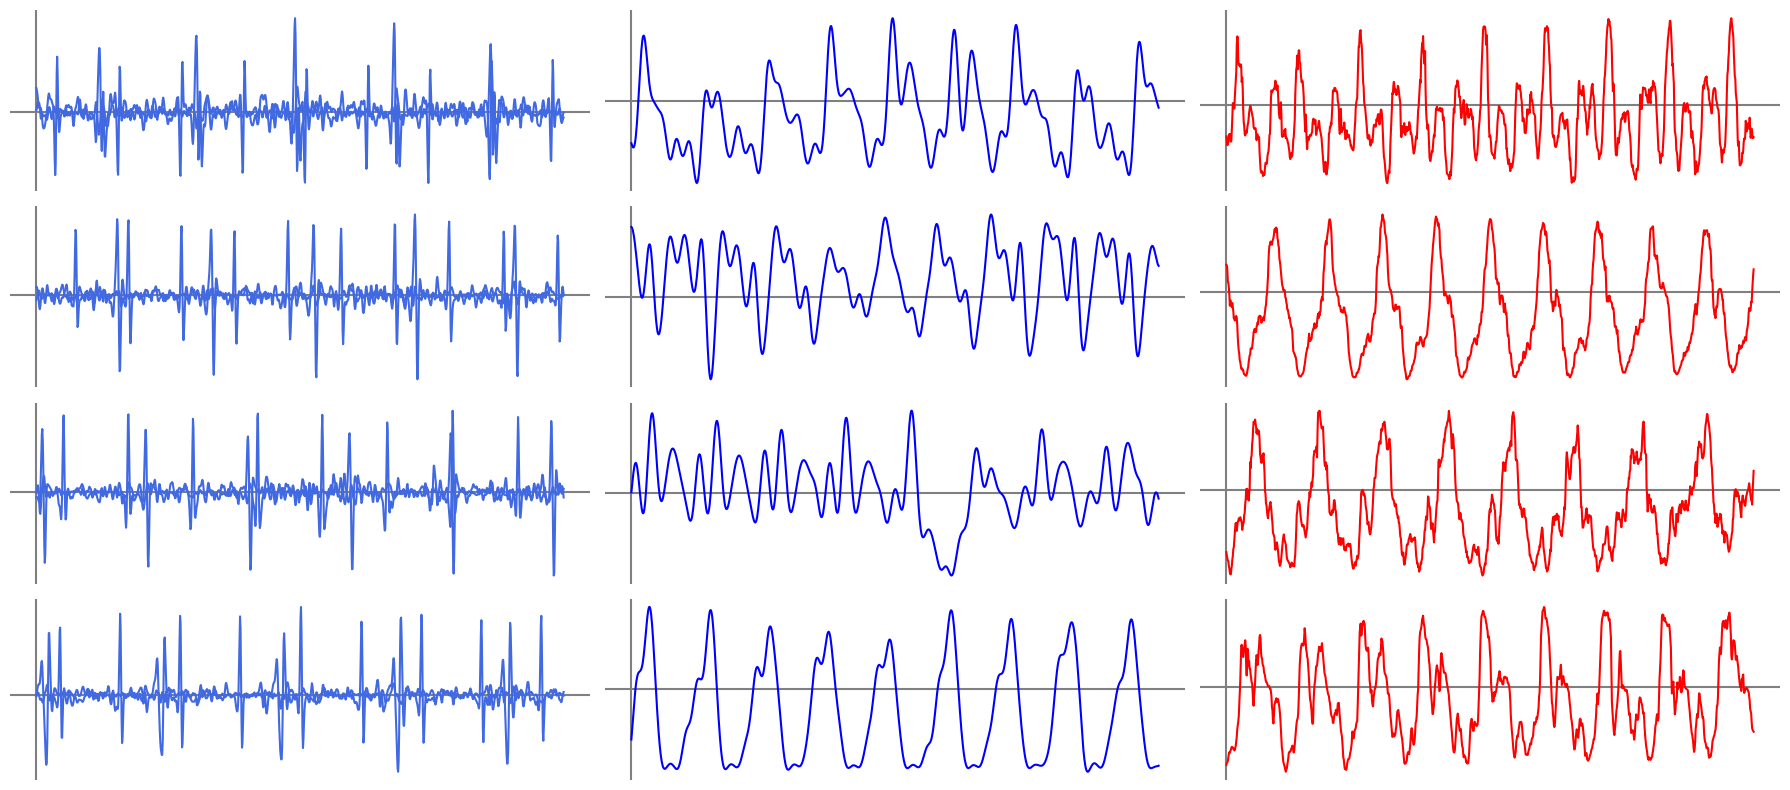

ValueError: For X (1065) and Y (80) with gouraud shading, A should have shape (80, 1065, 3) or (80, 1065, 4) or (80, 1065) or (85200,), not (80, 1065, 1)

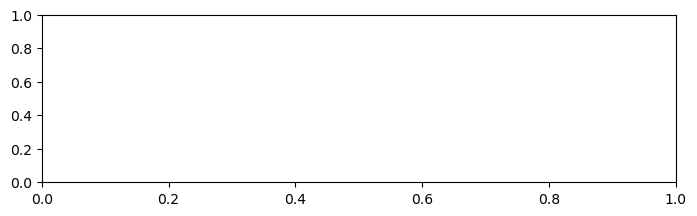

In [ ]:
# Grouped cross validation
tf.random.set_seed(33)
np.random.seed(33)

n_splits = 5
gkf = GroupKFold(n_splits=n_splits)

fold_rows = []
best_val_losses = []

# Create dirs
save_dir_model = './WaveNet_beat/models'
save_dir_loss  = './WaveNet_beat/logs'
save_dir_plots = './WaveNet_beat/plots'
os.makedirs(save_dir_model, exist_ok=True)
os.makedirs(save_dir_loss,  exist_ok=True)
os.makedirs(save_dir_plots, exist_ok=True)

n_epochs = 30
batch_size = 32

for fold_idx, (train_idx, val_idx) in enumerate(gkf.split(X, Y, groups=PATIENT_IDS), start=1):
    tr_pats = set(PATIENT_IDS[train_idx])  
    va_pats = set(PATIENT_IDS[val_idx])    
    assert tr_pats.isdisjoint(va_pats), "Patient leakage between train/val!"

    latent_dim = WIN
    model = modules.WaveNet_two_channel(input_shape=(latent_dim, 2))
    model.compile(optimizer="adam", loss="mae")

    # Train
    history = model.fit(
        X[train_idx], Y[train_idx],
        validation_data=(X[val_idx], Y[val_idx]),
        epochs=n_epochs,
        batch_size=batch_size,
        verbose=1
    )

    # Get best val loss across epochs
    val_losses = history.history.get('val_loss', [])
    best_val = float(np.min(val_losses)) if len(val_losses) else float(model.evaluate(X[val_idx], Y[val_idx], verbose=0))
    best_val_losses.append(best_val)

    # Save fold artifacts
    np.save(os.path.join(save_dir_loss, f'loss_fold{fold_idx}.npy'), history.history['loss'])
    np.save(os.path.join(save_dir_loss, f'val_loss_fold{fold_idx}.npy'), history.history.get('val_loss', []))
    model.save(os.path.join(save_dir_model, f'model_fold{fold_idx}.h5'))

    # sizes and unique record counts
    train_recs = np.unique(PATIENT_IDS[train_idx])
    val_recs   = np.unique(PATIENT_IDS[val_idx])

    fold_rows.append({
        "fold": fold_idx,
        "train_records": train_recs.size,
        "val_records":   val_recs.size,
        "train_segments": train_idx.size,
        "val_segments":   val_idx.size,
        "best_val_loss":  best_val
    })

# Summaries: per-fold table and mean ± std
df_folds = pd.DataFrame(fold_rows).sort_values("fold")
mean_loss = float(np.mean(best_val_losses))
std_loss  = float(np.std(best_val_losses, ddof=1))  # sample std

df_summary = pd.DataFrame(
    [{"metric": "val_loss", "mean": mean_loss, "std": std_loss}]
)

print("\nPer-fold results:\n", df_folds.to_string(index=False))
print("\nMean ± Std of best val_loss across folds:")
print(df_summary.to_string(index=False))

# quick qualitative plots from the LAST fold's val set
# Randomly select 4 ECG samples and compare real vs generated from the last fold's validation split
if val_idx.size >= 4:
    rng = np.random.default_rng(0)
    rand_val_idx = rng.choice(val_idx, size=4, replace=False)
    selected_ecgs = X[rand_val_idx]
    selected_real_dopplers = Y[rand_val_idx]
    generated_dopplers = model.predict(selected_ecgs, verbose=0).squeeze(-1)

    modules.plot_ecg_doppler_pairs(selected_ecgs, selected_real_dopplers, generated_dopplers)
    modules.plot_scalogram(selected_real_dopplers, generated_dopplers)

### Single patient-level train/val split

In [9]:
tf.random.set_seed(33)
np.random.seed(33)

gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=33)      
(train_idx, val_idx), = gss.split(X, Y, groups=PATIENT_IDS)       
np.save("idx_train.npy", train_idx)
np.save("idx_val.npy", val_idx)

Model: "WaveNet_two_channel_early_fusion"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ecg_fetal_maternal… │ (None, 1065, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_31 (Conv1D)  │ (None, 1065, 64)  │        192 │ ecg_fetal_matern… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_32 (Conv1D)  │ (None, 1065, 64)  │     81,984 │ conv1d_31[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_33 (Conv1D)  │ (None, 1065, 64)  │     81,984 │ conv1d_31[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_7          │ (None, 1065, 64)  │          0 │ conv1d_32[0][0],  │
│ (Multiply)          │                   │            │ conv1d_33[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 1065, 64)  │      4,160 │ conv1d_31[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 1065, 64)  │          0 │ multiply_7[0][0], │
│                     │                   │            │ conv1d_35[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 1065, 64)  │     81,984 │ add_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 1065, 64)  │     81,984 │ add_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_8          │ (None, 1065, 64)  │          0 │ conv1d_36[0][0],  │
│ (Multiply)          │                   │            │ conv1d_37[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_39 (Conv1D)  │ (None, 1065, 64)  │      4,160 │ add_8[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 1065, 64)  │          0 │ multiply_8[0][0], │
│                     │                   │            │ conv1d_39[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 1065, 64)  │     81,984 │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 1065, 64)  │     81,984 │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_9          │ (None, 1065, 64)  │          0 │ conv1d_40[0][0],  │
│ (Multiply)          │                   │            │ conv1d_41[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_43 (Conv1D)  │ (None, 1065, 64)  │      4,160 │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 1065, 64)  │          0 │ multiply_9[0][0], │
│                     │                   │            │ conv1d_43[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_44 (Conv1D)  │ (None, 1065, 64)  │     81,984 │ add_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_45 (Conv1D)  │ (None, 1065, 64)  │     81,984 │ add_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_10         │ (None, 1065, 64)  │          0 │ conv1d_44[0][0],  │
│ (Multiply)          │                   │            │ conv1d_45[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_47 (Conv1D)  │ (None, 1065, 64)  │      4,160 │ add_10[0][0]    

 Total params: 1,206,273 (4.60 MB)

 Trainable params: 1,206,273 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - loss: 0.4394 - val_loss: 0.4290
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - loss: 0.4143 - val_loss: 0.4238
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - loss: 0.4127 - val_loss: 0.4237
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - loss: 0.4124 - val_loss: 0.4210
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - loss: 0.4111 - val_loss: 0.4158
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - loss: 0.4072 - val_loss: 0.4167
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - loss: 0.4019 - val_loss: 0.3996
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - loss: 0.3952 - val_loss: 0.4020
Epoch 9/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - loss: 0.3898 - val_loss: 0.4067
Epoch 10/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - loss: 0.3833 - val_loss: 0.4201
Epoch 11/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - loss: 0.3772 - val_loss: 0.4224
Epoch 12/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step - loss: 0.3727 - val_lo


Split results:
         split  train_patients  val_patients  train_segments  val_segments  best_val_loss
patient_split              31             8             693           192       0.399618


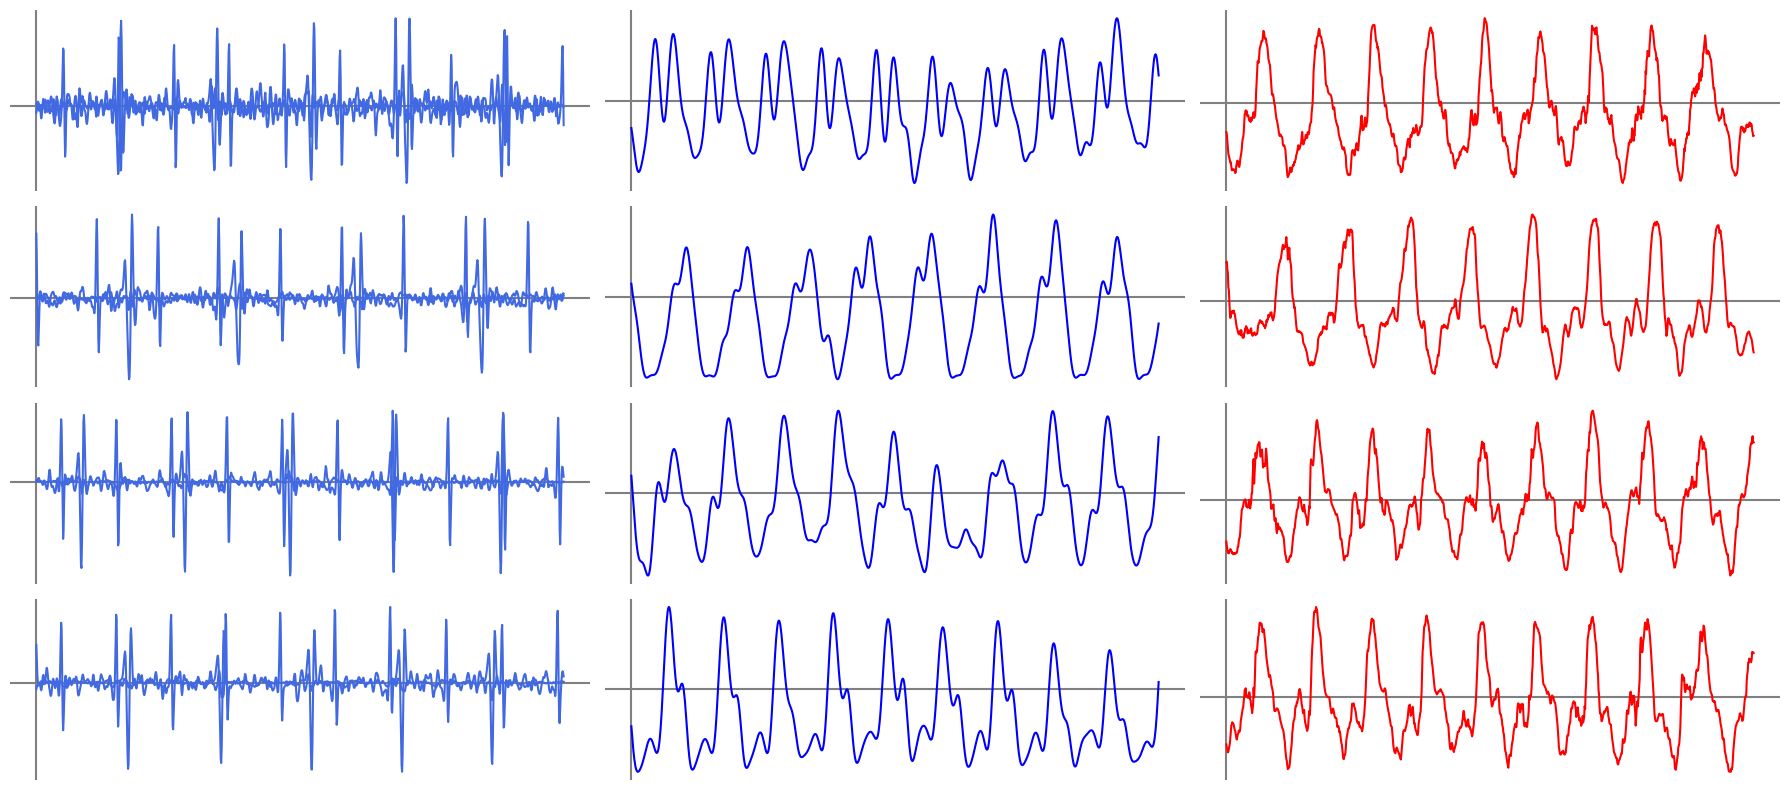

In [11]:
tr_pats = set(PATIENT_IDS[train_idx])                                    
va_pats = set(PATIENT_IDS[val_idx])                                      
assert tr_pats.isdisjoint(va_pats), "Patient leakage between train/val!" 

fold_rows = []            
best_val_losses = []     

save_dir_model = './WaveNet_beat/models'
save_dir_loss  = './WaveNet_beat/logs'
save_dir_plots = './WaveNet_beat/plots'
os.makedirs(save_dir_model, exist_ok=True)
os.makedirs(save_dir_loss,  exist_ok=True)
os.makedirs(save_dir_plots, exist_ok=True)

n_epochs = 20
batch_size = 32

latent_dim = WIN
model = modules.WaveNet_two_channel(input_shape=(latent_dim, 2))
model.compile(optimizer="adam", loss="mae")

history = model.fit(
    X[train_idx], Y[train_idx],
    validation_data=(X[val_idx], Y[val_idx]),
    epochs=n_epochs,
    batch_size=batch_size,
    verbose=1
)

val_losses = history.history.get('val_loss', [])
best_val = float(np.min(val_losses)) if len(val_losses) else float(model.evaluate(X[val_idx], Y[val_idx], verbose=0))
best_val_losses.append(best_val)

np.save(os.path.join(save_dir_loss, f'loss_split.npy'),     history.history['loss'])   
np.save(os.path.join(save_dir_loss, f'val_loss_split.npy'), val_losses)                
model.save(os.path.join(save_dir_model, f'model_patient_split.h5'))                    

train_patients = np.unique(PATIENT_IDS[train_idx])   
val_patients   = np.unique(PATIENT_IDS[val_idx])    

fold_rows.append({
    "split": "patient_split",                        
    "train_patients": train_patients.size,
    "val_patients":   val_patients.size,
    "train_segments": train_idx.size,
    "val_segments":   val_idx.size,
    "best_val_loss":  best_val
})

# Table(s)
df_split = pd.DataFrame(fold_rows)
print("\nSplit results:\n", df_split.to_string(index=False))

# qualitative plots on the validation set
if val_idx.size >= 4:
    rng = np.random.default_rng(0)
    rand_val_idx = rng.choice(val_idx, size=4, replace=False)

    showcase_idx_file = os.path.join(save_dir_plots, "val_showcase_idx.npy")
    np.save(showcase_idx_file, rand_val_idx)

    selected_ecgs = X[rand_val_idx]
    selected_real_dopplers = Y[rand_val_idx]
    generated_dopplers = model.predict(selected_ecgs, verbose=0).squeeze(-1)

    modules.plot_ecg_doppler_pairs(selected_ecgs, selected_real_dopplers, generated_dopplers)
    #modules.plot_scalogram(selected_real_dopplers, generated_dopplers)

### Archive segment-level split

In [7]:
WIN = int(WIN_SEC  * FS_TARGET)      # 3.75 s × 284 Hz = 1065
STEP = int(STEP_SEC * FS_TARGET)     # 50 % overlap

X, Y = [], []
for rec in range(1, 61):                
    fe_ecg284, mat_ecg284, env = load_record_two_channel(rec,
                              Path("/home/tsu25/envelops"),
                              Path("/labs/katebilab/NinFEA_Data/Processed_Data"))
    for s in range(0, len(env) - WIN, STEP):
        fe_ecg_win  = fe_ecg284[s:s+WIN].astype(np.float32, copy=False)
        mat_ecg_win = mat_ecg284[s:s+WIN].astype(np.float32, copy=False)
        env_win     = env[s:s+WIN].astype(np.float32, copy=False)

        # ECG per-window normalisation
        fe_ecg_win = (fe_ecg_win - fe_ecg_win.mean()) / (fe_ecg_win.std() + 1e-6)
        mat_ecg_win = (mat_ecg_win - mat_ecg_win.mean()) / (mat_ecg_win.std() + 1e-6)

        # stack to 2 channels: [:,0]=fetal, [:,1]=maternal  -> (WIN, 2)
        ecg_2ch_win = np.stack([fe_ecg_win, mat_ecg_win], axis=-1)

        # Doppler per-window normalization and add channel dim -> shape: (WIN, 1)
        env_min, env_ptp = env_win.min(), env_win.ptp()
        env_win = 2.0 * (env_win - env_min)/(env_ptp + 1e-6) - 1.0  # [-1, 1]
        env_win = env_win[:, None]

        X.append(ecg_2ch_win)         # Two channel ECG
        Y.append(env_win)             # (WIN,)  or  env_win[:, None]

X = np.asarray(X, dtype=np.float32)
Y = np.asarray(Y, dtype=np.float32)
print("Final shapes:", X.shape, Y.shape)   # (total_windows, 1065, 1) …

Final shapes: (885, 1065, 2) (885, 1065, 1)


In [8]:
ECG_train, ECG_test, ENV_train, ENV_test = train_test_split(
    X, Y, test_size=0.2, random_state=0, shuffle=True
)

### Model Training

In [9]:
# Set latent dimension to window size for input
latent_dim = WIN
WaveNet = modules.WaveNet_two_channel(input_shape=(latent_dim, 2))
WaveNet.compile(optimizer="adam", loss="mae")

n_epochs = 30

history = WaveNet.fit(ECG_train,
                      ENV_train,
                      epochs=n_epochs,
                      batch_size=32,
                      validation_split=0.1)

save_dir_model = './WaveNet_beat/models'
save_dir_loss = './WaveNet_beat/logs'
save_dir_plots = './WaveNet_beat/plots'
os.makedirs(save_dir_model, exist_ok=True)
WaveNet.save(os.path.join(save_dir_model, 'model_v3_dual.h5'))

os.makedirs(save_dir_loss, exist_ok=True)
np.save(os.path.join(save_dir_loss, 'loss_1.npy'), history.history['loss'])

os.makedirs(save_dir_plots, exist_ok=True)
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('./WaveNet_beat/plots/loss_3.png')
plt.show()

# Show some random generated
# Randomly select 4 ECG samples and their corresponding real Doppler from the dataset
random_indices = np.random.choice(len(ECG_test), 4, replace=False)
selected_ecgs = ECG_test[random_indices]
selected_real_dopplers = ENV_test[random_indices]
# Generate Doppler using the model
generated_dopplers = WaveNet.predict(selected_ecgs).squeeze(-1)
# Plot the selected ECGs, real Dopplers, and their corresponding generated Doppler signals
modules.plot_ecg_doppler_pairs(selected_ecgs, selected_real_dopplers, generated_dopplers)
modules.plot_scalogram(selected_real_dopplers, generated_dopplers)

Model: "WaveNet_two_channel_early_fusion"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ecg_fetal_maternal… │ (None, 1065, 2)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 1065, 64)  │        192 │ ecg_fetal_matern… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 1065, 64)  │     81,984 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 1065, 64)  │     81,984 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1065, 64)  │          0 │ conv1d_1[0][0],   │
│                     │                   │            │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 1065, 64)  │      4,160 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1065, 64)  │          0 │ multiply[0][0],   │
│                     │                   │            │ conv1d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 1065, 64)  │     81,984 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 1065, 64)  │     81,984 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_1          │ (None, 1065, 64)  │          0 │ conv1d_5[0][0],   │
│ (Multiply)          │                   │            │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 1065, 64)  │      4,160 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1065, 64)  │          0 │ multiply_1[0][0], │
│                     │                   │            │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_9 (Conv1D)   │ (None, 1065, 64)  │     81,984 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 1065, 64)  │     81,984 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_2          │ (None, 1065, 64)  │          0 │ conv1d_9[0][0],   │
│ (Multiply)          │                   │            │ conv1d_10[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 1065, 64)  │      4,160 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 1065, 64)  │          0 │ multiply_2[0][0], │
│                     │                   │            │ conv1d_12[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 1065, 64)  │     81,984 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 1065, 64)  │     81,984 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 1065, 64)  │          0 │ conv1d_13[0][0],  │
│ (Multiply)          │                   │            │ conv1d_14[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_16 (Conv1D)  │ (None, 1065, 64)  │      4,160 │ add_2[0][0]     

 Total params: 1,206,273 (4.60 MB)

 Trainable params: 1,206,273 (4.60 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - loss: 0.4419 - val_loss: 0.4203
Epoch 2/30
 3/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - loss: 0.4194

KeyboardInterrupt: 

### Evaluation

In [8]:
# ---------- helper that builds an Activation layer regardless of config -----
def _act_builder(act_fn):
    # Keras deserializer calls obj(**config); we pop unknown keys here
    return lambda **cfg: tf.keras.layers.Activation(
        act_fn,
        name=cfg.pop("name", None),           # keep layer name if present
        trainable=cfg.pop("trainable", True)  # default True
    )

custom_objects = {
    "Tanh":      _act_builder(tf.keras.activations.tanh),
    "Relu":      _act_builder(tf.keras.activations.relu),
    "Silu":      _act_builder(tf.keras.activations.silu),
    "Sigmoid":   _act_builder(tf.keras.activations.sigmoid),
    "Softmax":   _act_builder(tf.keras.activations.softmax),
    # LeakyReLU is already a dedicated layer class, expose it directly
    "LeakyRelu": lambda **cfg: tf.keras.layers.LeakyReLU(
        negative_slope=cfg.pop("alpha", 0.2),  # Keras uses `negative_slope`
        name=cfg.pop("name", None),
        **cfg                                    # trainable, dtype, etc.
    ),
}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


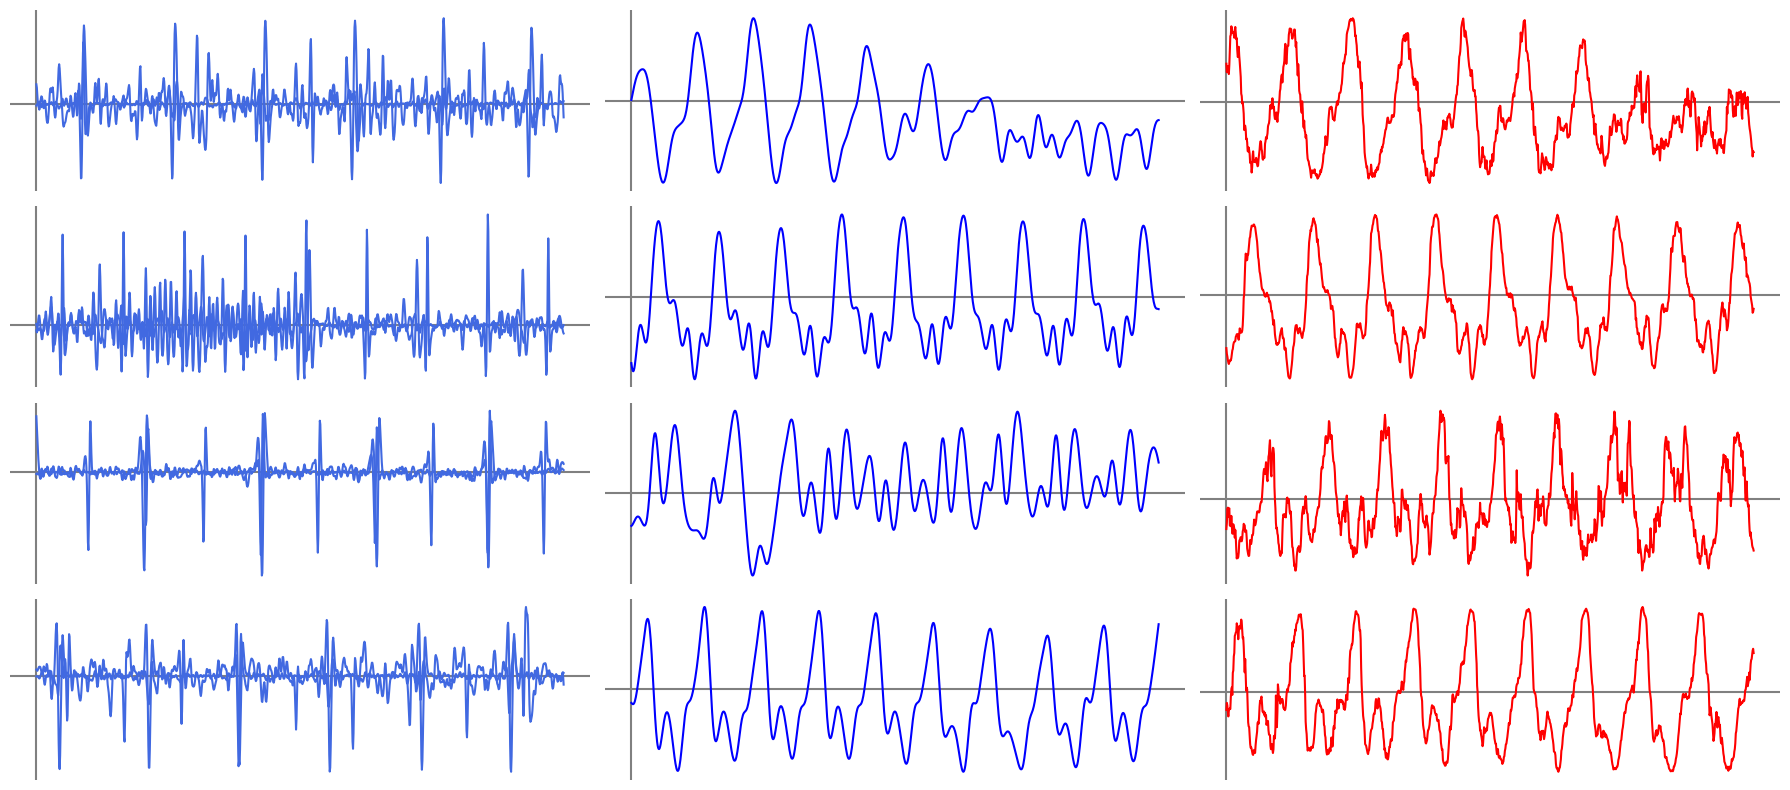

ValueError: For X (1065) and Y (80) with gouraud shading, A should have shape (80, 1065, 3) or (80, 1065, 4) or (80, 1065) or (85200,), not (80, 1065, 1)

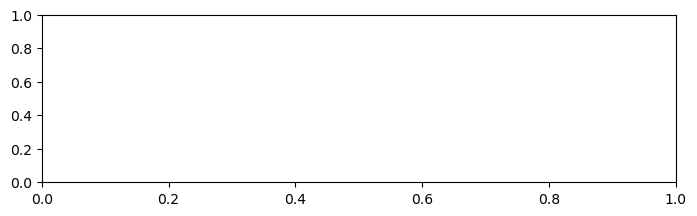

In [9]:
model_path = Path("./WaveNet_beat/models/model_v3_dual.h5")
WaveNet = tf.keras.models.load_model(model_path, custom_objects=custom_objects, compile=False)


save_dir_plots = './WaveNet_beat/plots'
os.makedirs(save_dir_plots, exist_ok=True)

# Show some random generated
# Randomly select 4 ECG samples and their corresponding real Doppler from the dataset
random_indices = np.random.choice(len(ECG_test), 4, replace=False)
selected_ecgs = ECG_test[random_indices]
selected_real_dopplers = ENV_test[random_indices]
# Generate Doppler using the model
generated_dopplers = WaveNet.predict(selected_ecgs).squeeze(-1)
# Plot the selected ECGs, real Dopplers, and their corresponding generated Doppler signals
modules.plot_ecg_doppler_pairs(selected_ecgs, selected_real_dopplers, generated_dopplers)
modules.plot_scalogram(selected_real_dopplers, generated_dopplers)

In [16]:
# WaveNet outputs (batch, 1065, 1).  Squeeze to 2-D for metric calls
generated_dopplers = WaveNet.predict(ECG_test, batch_size=64).squeeze(-1)
DUS_array_test = ENV_test

#generated_dopplers = generated_dopplers.squeeze(-1)
DUS_array_test = DUS_array_test.squeeze(-1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step


In [18]:
generated_dopplers.shape
DUS_array_test.shape

(177, 1065)

In [19]:
# Calculate metrics
rmse = calculate_rmse(generated_dopplers, DUS_array_test)
mae = calculate_mae(generated_dopplers, DUS_array_test)
kld = calculate_kld(generated_dopplers, DUS_array_test)
dtw_distance = calculate_dtw(generated_dopplers, DUS_array_test)
correlation = calculate_correlation(generated_dopplers, DUS_array_test)
sdtw = calculate_soft_dtw(generated_dopplers, DUS_array_test)
ed = calculate_euclidean_distance(generated_dopplers, DUS_array_test)
rdd = calculate_rdd(generated_dopplers, DUS_array_test)
prd = calculate_prd(generated_dopplers, DUS_array_test)
entropy = calculate_spectral_entropy(generated_dopplers, DUS_array_test)
psd = calculate_psd_difference(generated_dopplers, DUS_array_test)
centroid = calculate_spectral_centroid_difference(generated_dopplers, DUS_array_test)
flatness = calculate_flatness_difference(generated_dopplers, DUS_array_test)
fd = calculate_discrete_frechet_distance(generated_dopplers, DUS_array_test)

# Print results
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"KLD: {kld}")
print(f"DTW Distance: {dtw_distance}")
print(f"Correlation: {correlation}")
print(f"Soft DTW: {sdtw}")
print(f"ED: {ed}")
print(f"RDD: {rdd}")
print(f"prd: {prd}")
print(f"spectral entropy: {entropy}")
print(f"psd difference: {psd}")
print(f"centroid difference: {centroid}")
print(f"spectral flatness: {flatness}")
print(f"fd: {fd}")

RMSE: 0.32439538836479187
MAE: 0.240181103348732
KLD: 0.04070133772836867
DTW Distance: 1768.4367516010414
Correlation: 0.7667200844429616
Soft DTW: 19836.828125
ED: 140.84326171875
RDD: 4913.607697740113
prd: 61.864495277404785
spectral entropy: 0.14843368530273438
psd difference: 0.021672798320651054
centroid difference: 11.012525290439799
spectral flatness: 0.021002011373639107
fd: 5.96348762512207


In [10]:
import pandas as pd

metrics = [
    ("RMSE",               0.3981609642505646,  "Moderate point-wise error (≈ 20 % scale)"),
    ("MAE",                0.30351194739341736, "Typical absolute deviation per sample"),
    ("KLD",                0.1525541972389974,  "Amplitude distribution close; small divergence"),
    ("DTW",                2270.005806179246,   "Avg. mis-alignment ≈ 2 samples (warped)"),
    ("Pearson r",          0.5534738365210246,  "Medium linear similarity"),
    ("Soft-DTW",           29884.1015625,       "Residual timing/shape mismatch remains"),
    ("Euclidean dist.",    172.8701629638672,   "Cumulative point-wise error energy"),
    ("RDD",                9.590573044429379e9, "Scale-sensitive; inflated by small denom."),
    ("PRD",                75.98966360092163,   "Error energy still high; noticeable distortion"),
    ("Spectral entropy Δ", 0.7945833206176758,  "Generated PSD flatter (peaks lost)"),
    ("PSD ℓ2 Δ",           0.033398982137441635,"Overall spectra fairly close"),
    ("Centroid Δ",         24.94859342651444,   "Energy shifted higher; less low-freq content"),
    ("Flatness Δ",         0.31084978580474854, "Generated envelopes noisier / less tonal"),
    ("Fréchet dist.",      10.08528995513916,   "Global shape drift remains")
]

df_metrics = pd.DataFrame(metrics, columns=["Metric", "Value", "Interpretation"])
df_metrics["Value"] = df_metrics["Value"].map("{:.6f}".format)

In [11]:
df_metrics

,Metric,Value,Interpretation
0,RMSE,0.398161,Moderate point-wise error (≈ 20 % scale)
1,MAE,0.303512,Typical absolute deviation per sample
2,KLD,0.152554,Amplitude distribution close; small divergence
3,DTW,2270.005806,Avg. mis-alignment ≈ 2 samples (warped)
4,Pearson r,0.553474,Medium linear similarity
5,Soft-DTW,29884.101562,Residual timing/shape mismatch remains
6,Euclidean dist.,172.870163,Cumulative point-wise error energy
7,RDD,9590573044.429379,Scale-sensitive; inflated by small denom.
8,PRD,75.989664,Error energy still high; noticeable distortion
9,Spectral entropy Δ,0.794583,Generated PSD flatter (peaks lost)
